In [50]:
#%pip install pandas
#%pip install numpy
#%pip install langchain
#%pip install langchain-community
#%pip install langchain-groq
#%pip install sentence-transformers
#%pip install -U langchain-community faiss-cpu langchain-openai tiktoken

In [63]:
import pandas as pd
import numpy as np
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
import os 
import json
from langchain_core.runnables import RunnablePassthrough
import csv 
pd.set_option('display.max_colwidth', None)
#encounter key
#encounterKey = 'D09917F7A5881C'
#encounterKey = 'D12AE2EDBFCAEA'
encounterKey= 'D068E26FFF9F43'

In [64]:
base_path = "F:/LangChain/data/"
noteConcepts = pd.read_csv(base_path + 'noteConcepts.txt', sep="|")
encounters = pd.read_csv(base_path + 'encounters.txt', sep="|")
orders = pd.read_csv(base_path + 'orders.txt', sep="|")
hospitalAcquiredDx = pd.read_csv(base_path + 'hospitalAcquiredDx.txt', sep="|")
noteText = pd.read_csv(base_path + 'noteText.csv')
presentOnAdmitDx = pd.read_csv(base_path + 'presentOnAdmitDx.txt', sep="|")

#filter all dfs to the selected EncounterKey
#noteConcepts = noteConcepts[noteConcepts['EncounterKey'] == encounterKey]
orders = orders[orders['EncounterKey'] == encounterKey]
hospitalAcquiredDx = hospitalAcquiredDx[hospitalAcquiredDx['EncounterKey'] == encounterKey]
noteText = noteText[noteText['EncounterKey'] == encounterKey]
presentOnAdmitDx = presentOnAdmitDx[presentOnAdmitDx['EncounterKey'] == encounterKey]
encounters = encounters[encounters['EncounterKey'] == encounterKey]

In [65]:
presentOnAdmitDx.head()

,EncounterKey,DxName
92,D068E26FFF9F43,*Unspecified


In [66]:
encounters.head()

encounter_hx = encounters[['PtAdmitDate', 'PtDischargeDate', 'DRG', 'AdmissionOrigin','PrimaryDx']]
encounter_hx = encounter_hx.to_json(orient="records")
encounter_hx = json.loads(encounter_hx)

print(json.dumps(encounter_hx, indent=4))

presentOnAdmitDx_l = presentOnAdmitDx['DxName'].tolist()
hospitalAcquiredDx_l = hospitalAcquiredDx['DxName'].tolist()
print("presentOnAdmitDx" + str(presentOnAdmitDx_l))
print("hospitalAcquiredDx" + str(hospitalAcquiredDx_l))

[
    {
        "PtAdmitDate": "2023-09-15",
        "PtDischargeDate": "2023-09-21",
        "DRG": "DORSAL AND LUMBAR FUSION PROCEDURE EXCEPT FOR CURVATURE OF BACK",
        "AdmissionOrigin": "OR Admission",
        "PrimaryDx": "Spondylolisthesis, lumbosacral region"
    }
]
presentOnAdmitDx['*Unspecified']
hospitalAcquiredDx['*Unspecified']


In [67]:
orders.head()
#order by OrderDate
orders = orders.sort_values(by='OrderDate')
#change orders to a json with the keys being OrderDate, OrderName, Frequency, DurationDays, Mode, and Source
orders = orders[['OrderDate', 'OrderName', 'Frequency', 'DurationDays', 'Mode', 'Source']]
orders = orders.to_json(orient="records")
orders = json.loads(orders)

print(json.dumps(orders, indent=4))

[
    {
        "OrderDate": "2023-09-15",
        "OrderName": "lansoprazole (PREVACID) capsule 30 mg",
        "Frequency": "Every Morning Before Breakfast Scheduled",
        "DurationDays": 5.0,
        "Mode": "Inpatient",
        "Source": "Ord Rec Admission Reorder PTA"
    }
]


<Axes: >

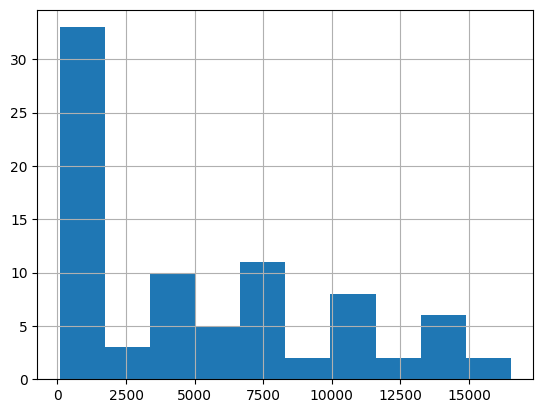

In [55]:

#show the length of the noteText column as a distribution of the lengths
noteText['NoteTextLength'] = noteText['NoteText'].str.len()
noteText['NoteTextLength'].hist()

In [56]:
noteText.describe()

,NoteTextLength
count,82.000000
mean,5324.926829
std,4733.228465
min,88.000000
25%,883.500000
50%,4487.500000
75%,8274.500000
max,16523.000000


In [57]:
noteText = noteText.sort_values(by='NoteDate')
noteText.head(112)

deid_note_key    EncounterKey    NoteDate DepartmentSpecialty  \
17454  D8ECF502009244  D12AE2EDBFCAEA  2023-09-10   Inpatient Nursing   
17032  D8B1B2DFFF4853  D12AE2EDBFCAEA  2023-09-10   Inpatient Nursing   
27465  DE1506CE22E237  D12AE2EDBFCAEA  2023-09-10   Inpatient Nursing   
27502  DE1983E889154F  D12AE2EDBFCAEA  2023-09-10   Inpatient Nursing   
20307  DA5F46FC226B60  D12AE2EDBFCAEA  2023-09-10   Inpatient Nursing   
...               ...             ...         ...                 ...   
409    D02EF82AB2FE75  D12AE2EDBFCAEA  2023-09-25   Inpatient Nursing   
30525  DFA74F278B4CF2  D12AE2EDBFCAEA  2023-09-26   Inpatient Nursing   
13784  D709670DC019C1  D12AE2EDBFCAEA  2023-09-26   Inpatient Nursing   
6932   D3849C45BF4DA4  D12AE2EDBFCAEA  2023-09-26   Inpatient Nursing   
26196  DD6F21F8CD17BA  D12AE2EDBFCAEA  2023-09-26   Inpatient Nursing   

        ProviderSpecialty         ProviderType  \
17454                 NaN           Pharmacist   
17032  Emergency Medicine  Physician Assistant   
27465                UCSF            Physician   
27502  Nurse Practitioner   Nurse Practitioner   
20307  Emergency Medicine  Physician Assistant   
...                   ...                  ...   
409    Nurse Practitioner   Nurse Practitioner   
30525                 NaN         Case Manager   
13784                 NaN     Registered Nurse   
6932   Nurse Practitioner   Nurse Practitioner   
26196                 NaN           Pharmacist   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [41]:
import textwrap
from IPython.display import display, Markdown
note = noteText['NoteText'].iloc[1]
formatted_text = textwrap.fill(note, width=80)
display(Markdown(f"```\n{formatted_text}\n```"))

```
CT ANGIOGRAM CHEST    08/27/2023 9:56 PM"  Axial 1.25 mm  non ECG-gated images
were obtained after the administration of intravenous contrast."    Additional
3-dimensional post-processing was performed on a dedicated workstation."
Iohexol 350 - 120 mL - Intravenous"    RADIATION DOSE INDICATORS:"  Exposure
Events: 5  CTDIvol Min: 8.5 mGy CTDIvol Max: 9.9 mGy DLP: 1146.6 mGy.cm. The
following accession numbers are related to this dose report **********"
FINDINGS:"      AORTA/VASCULAR:"  Cardiac motion limits evaluation of the aortic
root and ascending aorta. Normal caliber thoracic aorta. No evidence of acute
aortic injury."    LUNGS:"  Patchy atelectasis. Diffuse cylindrical
bronchiectasis. No suspicious pulmonary nodules."    PLEURA:"  Small right
pleural effusion. Left pleural effusion has resolved."    CLINICAL HISTORY:  pls
r/o *****. "  MEDIASTINUM: "  No suspicious lymphadenopathy."    HEART/*****
*****:"  Biatrial enlargement which may be seen in setting of atrial
fibrillation."    BONES/SOFT TISSUES:"  No suspicious osseous lesions."
VISIBLE ABDOMEN:"    Please see dedicated Abdomen and Pelvis CT report."
ADDITIONAL HISTORY: None"    COMPARISON:   CT chest 07/26/2023"    TECHNIQUE:"
```